In [23]:
%matplotlib inline

import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Case study - Conflict mapping: mining sites in eastern DR Congo

In this case study, we will explore a dataset on artisanal mining sites located in eastern DR Congo.

**Note**: this tutorial is meant as a hands-on session, and most code examples are provided as exercises to be filled in. I highly recommend actually trying to do this yourself, but if you want to follow the solved tutorial, you can find this in the `_solved` directory.

---

#### Background

[IPIS](http://ipisresearch.be/), the International Peace Information Service, manages a database on mining site visits in eastern DR Congo: http://ipisresearch.be/home/conflict-mapping/maps/open-data/

Since  2009, IPIS has visited artisanal mining sites in the region during various data collection campaigns. As part of these campaigns, surveyor teams visit mining sites in the field, meet with miners and complete predefined questionnaires. These contain questions about the mining site, the minerals mined at the site and the armed groups possibly present at the site.

Some additional links:

* Tutorial on the same data using R from IPIS (but without geospatial aspect): http://ipisresearch.be/home/conflict-mapping/maps/open-data/open-data-tutorial/
* Interactive web app using the same data: http://www.ipisresearch.be/mapping/webmapping/drcongo/v5/

## 1. Importing and exploring the data

### The mining site visit data

IPIS provides a WFS server to access the data. We can send a query to this server to download the data, and load the result into a geopandas GeoDataFrame:

In [2]:
import requests
import json
import geopandas as gpd

wfs_url = "http://geo.ipisresearch.be/geoserver/public/ows"
params = dict(service='WFS', version='1.0.0', request='GetFeature',
              typeName='public:cod_mines_curated_all_opendata_p_ipis', outputFormat='json')

r = requests.get(wfs_url, params=params)
data_features = json.loads(r.content.decode('UTF-8'))
data_visits = gpd.GeoDataFrame.from_features(data_features, crs={'init': 'epsg:4326'})

However, the data is also provided in the tutorial materials as a GeoJSON file, so it is certainly available during the tutorial.

<div class="alert alert-success">
 <b>EXERCISE</b>:
 <ul>
  <li>Read the GeoJSON file `data/cod_mines_curated_all_opendata_p_ipis.geojson` using geopandas, and call the result `data_visits`.</li>
  <li>Inspect the first 5 rows, and check the number of observations</li>
 </ul> 

</div>

In [3]:
# %load _solved/solutions/case-conflict-mapping3.py
data_visits.head(5)

,armed_group1,armed_group2,buying_minerals_armed_group1,buying_minerals_armed_group2,collectivite,commerce_taxation_armed_group1,commerce_taxation_armed_group2,digging_armed_group1,digging_armed_group2,entrance_taxation_armed_group1,...,taxation_armed_group2,territoire,type_armed_group1,type_armed_group2,vid,village,visit_date,visit_onsite,visit_onsite_novisitreason,workers_numb
0,None,None,NaN,NaN,Bapere,NaN,NaN,NaN,NaN,NaN,...,NaN,Lubero,0,0,1,Maendeleo,2009-01-01Z,1,None,300.0
1,None,None,NaN,NaN,Bapere,NaN,NaN,NaN,NaN,NaN,...,NaN,Lubero,0,0,2,Tembe,2009-01-01Z,1,None,110.0
2,FARDC,Maï-Maï Simba,NaN,NaN,Bapere,NaN,NaN,NaN,NaN,NaN,...,NaN,Lubero,FARDC - Pas de données sur les ingérences,Groupe armé local,3,Ehoto,2009-01-01Z,1,None,NaN
3,FDLR,Maï-Maï,NaN,NaN,Bamate,NaN,NaN,NaN,NaN,NaN,...,NaN,Lubero,Groupe armé étranger,Groupe armé local,4,Vunyakavulivwa,2009-01-01Z,1,None,NaN
4,FDLR,None,NaN,NaN,Batangi,NaN,NaN,NaN,NaN,NaN,...,NaN,Lubero,Groupe armé étranger,0,5,Ngohi,2009-01-01Z,1,None,NaN


In [4]:
# %load _solved/solutions/case-conflict-mapping4.py
data_visits.columns

Index(['armed_group1', 'armed_group2', 'buying_minerals_armed_group1',
       'buying_minerals_armed_group2', 'collectivite',
       'commerce_taxation_armed_group1', 'commerce_taxation_armed_group2',
       'digging_armed_group1', 'digging_armed_group2',
       'entrance_taxation_armed_group1', 'entrance_taxation_armed_group2',
       'final_destination_mineral1', 'final_destination_mineral2',
       'final_destination_mineral3', 'forced_labour_armed_group1',
       'forced_labour_armed_group2', 'frequency_armed_group1',
       'frequency_armed_group2', 'geometry', 'groupement', 'interference',
       'is_3t_mine', 'is_gold_mine', 'itsci', 'latitude', 'location_origin',
       'longitude', 'mercury', 'mineral1', 'mineral2', 'mineral3',
       'monopoly_armed_group1', 'monopoly_armed_group2', 'name', 'pcode',
       'pillaging_armed_group1', 'pillaging_armed_group2', 'presence',
       'project', 'province', 'province_old', 'qualification',
       'selling_points_mineral1', 'selling_po

In [5]:
# %load _solved/solutions/case-conflict-mapping5.py
data_visits.shape

(4364, 61)

The provided dataset contains a lot of information, much more than we are going to use in this tutorial. Therefore, we will select a subset of the column:

In [6]:
data_visits = data_visits[['vid', 'project', 'visit_date', 'name', 'pcode', 'workers_numb', 'interference', 'armed_group1', 'mineral1', 'geometry']]

In [7]:
data_visits.head()

,vid,project,visit_date,name,pcode,workers_numb,interference,armed_group1,mineral1,geometry
0,1,IPIS - 2009,2009-01-01Z,Eohe,codmine00191,300.0,NaN,None,Or,POINT (28.71258 0.33188)
1,2,IPIS - 2009,2009-01-01Z,Eita,codmine00192,110.0,NaN,None,Or,POINT (28.69916 0.32153)
2,3,IPIS - 2009,2009-01-01Z,Mungu Iko,codmine00242,NaN,NaN,FARDC,Or,POINT (28.1851423 0.54499175)
3,4,IPIS - 2009,2009-01-01Z,Kiviri/Tayna,codmine00260,NaN,NaN,FDLR,Or,POINT (28.884528 -0.352529)
4,5,IPIS - 2009,2009-01-01Z,Makanga,codmine00272,NaN,NaN,FDLR,Or,POINT (28.903945 -0.036707)


Before starting the actual geospatial tutorial, we will use some more advanced pandas queries to construct a subset of the data that we will use further on: 

In [8]:
# Take only the data of visits by IPIS
data_ipis = data_visits[data_visits['project'].str.contains('IPIS') & (data_visits['workers_numb'] > 0)]

In [10]:
# For those mining sites that were visited multiple times, take only the last visit
data_ipis_lastvisit = data_ipis.sort_values('visit_date').groupby('pcode', as_index=False).last()

In [13]:
type(data_ipis_lastvisit)

pandas.core.frame.DataFrame

In [14]:
data = gpd.GeoDataFrame(data_ipis_lastvisit, crs=data_visits.crs)

### Data on protected areas in the same region

Next to the mining site data, we are also going to use a dataset on protected areas (national parks) in Congo. This dataset was downloaded from http://www.wri.org/our-work/project/congo-basin-forests/democratic-republic-congo#project-tabs and included in the tutorial repository: `data/cod_conservation.zip`.

<div class="alert alert-success">
 <b>EXERCISE</b>:
 <ul>
  <li>Extract the `data/cod_conservation.zip` archive, and read the shapefile contained in it. Assign the resulting GeoDataFrame to a variable named `protected_areas`.</li>
  <li>Quickly plot the GeoDataFrame.</li>
 </ul> 
</div>

In [30]:
# %load _solved/solutions/case-conflict-mapping10.py
protected_areas = gpd.read_file('D:\GIS\geopandas-tutorial-master\data\Conservation\RDC_aire_protegee_2013.shp')

In [31]:
# %load _solved/solutions/case-conflict-mapping11.py
protected_areas.crs

{'proj': 'merc',
 'lon_0': 0,
 'lat_ts': 5,
 'x_0': 0,
 'y_0': 0,
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': True}

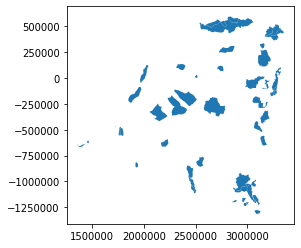

In [32]:
protected_areas.plot()

### Conversion to a common Coordinate Reference System

We will see that both datasets use a different Coordinate Reference System (CRS). For many operations, however, it is important that we use a consistent CRS, and therefore we will convert both to a commong CRS.

But first, we explore problems we can encounter related to CRSs.

---

[Goma](https://en.wikipedia.org/wiki/Goma) is the capital city of North Kivu province of Congo, close to the border with Rwanda. It's coordinates are 1.66°S 29.22°E.

<div class="alert alert-success">
 <b>EXERCISE</b>:
 <ul>
  <li>Create a single Point object representing the location of Goma. Call this `goma`.</li>
  <li>Calculate the distances of all mines to Goma, and show the 5 smallest distances (mines closest to Goma).</li>
 </ul> 
</div>

In [24]:
# %load _solved/solutions/case-conflict-mapping12.py
goma = Point(29.22, -1.66)

In [25]:
# %load _solved/solutions/case-conflict-mapping13.py
dist_goma = data.distance(goma)

In [26]:
dist_goma.nsmallest(5)

1538    39.227613
1563    39.228587
1540    39.264559
1510    39.266065
1511    39.270476
dtype: float64

In [ ]:
# %load _solved/solutions/case-conflict-mapping14.py

In [ ]:
# %load _solved/solutions/case-conflict-mapping15.py

The distances we see here in degrees, which is not helpful for interpreting those distances. That is a reason we will convert the data to another coordinate reference system (CRS) for the remainder of this tutorial.

<div class="alert alert-success">
 <b>EXERCISE</b>:
 <ul>
  <li>Make a visualization of the national parks and the mining sites on a single plot.</li>
 </ul> 
 
<p>Check the first section of the [04-more-on-visualization.ipynb](04-more-on-visualization.ipynb) notebook for tips and tricks to plot with GeoPandas.</p>
</div>

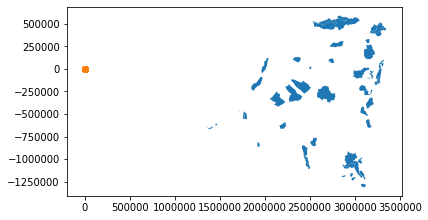

In [33]:
# %load _solved/solutions/case-conflict-mapping16.py
ax = protected_areas.plot()
data.plot(ax=ax, color='C1')

You will notice that the protected areas and mining sites do not map to the same area on the plot. This is because the Coordinate Reference Systems (CRS) differ for both datasets. Another reason we will need to convert the CRS!

Let's check the Coordinate Reference System (CRS) for both datasets.

The mining sites data uses the [WGS 84 lat/lon (EPSG 4326)](http://spatialreference.org/ref/epsg/4326/) CRS:

In [34]:
data.crs

{'init': 'epsg:4326'}

The protected areas dataset, on the other hand, uses a [WGS 84 / World Mercator (EPSG 3395)](http://spatialreference.org/ref/epsg/wgs-84-world-mercator/) projection (with meters as unit):

In [35]:
protected_areas.crs

{'proj': 'merc',
 'lon_0': 0,
 'lat_ts': 5,
 'x_0': 0,
 'y_0': 0,
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': True}

We will convert both datasets to a local UTM zone, so we can plot them together and that distance-based calculations give sensible results.

To find the appropriate UTM zone, you can check http://www.dmap.co.uk/utmworld.htm or https://www.latlong.net/lat-long-utm.html, and in this case we will use UTM zone 35, which gives use EPSG 32735: https://epsg.io/32735

<div class="alert alert-success">
 <b>EXERCISE</b>:
 <ul>
  <li>Convert both datasets (`data` and `protected_areas`) to EPSG 32735. Name the results `data_utm` and `protected_areas_utm`.</li>
  <li>Try again to visualize both datasets on a single map.</li>
 </ul> 

</div>

In [36]:
# %load _solved/solutions/case-conflict-mapping19.py
data_utm = data.to_crs(epsg=32735)

In [37]:
protected_areas_utm = protected_areas.to_crs(data_utm.crs)

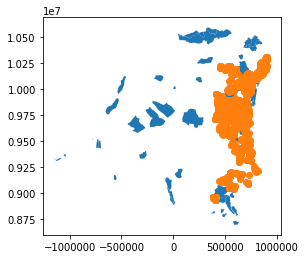

In [38]:
# %load _solved/solutions/case-conflict-mapping20.py
ax = protected_areas_utm.plot()
data_utm.plot(ax=ax, color='C1')

### More advanced visualizations

<p>For the following exercises, check the first section of the [04-more-on-visualization.ipynb](04-more-on-visualization.ipynb) notebook for tips and tricks to plot with GeoPandas.</p>

<div class="alert alert-success">
 <b>EXERCISE</b>:
 <ul>
  <li>Make a visualization of the national parks and the mining sites on a single plot.</li>
  <li>Pay attention to the following details:
     <ul>
      <li>Make the figure a bit bigger.</li>
      <li>The protected areas should be plotted in green</li>
      <li>For plotting the mining sites, adjust the markersize and use an `alpha=0.5`.</li>
      <li>Remove the figure border and x and y labels (coordinates)</li>
     </ul> 
   </li>
 </ul> 
</div>

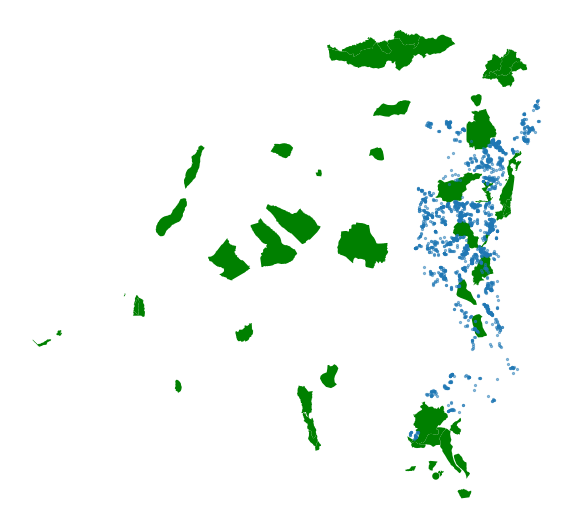

In [42]:
# %load _solved/solutions/case-conflict-mapping21.py
ax = protected_areas_utm.plot(figsize=(10, 10), color='green')
data_utm.plot(ax=ax, markersize=5, alpha=0.5)
ax.set_axis_off()

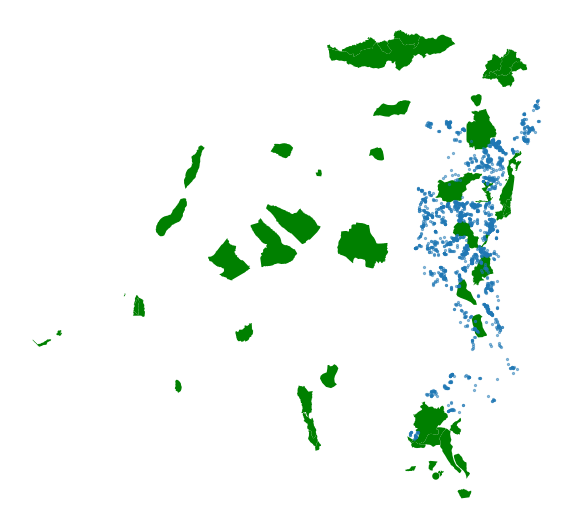

In [43]:
# %load _solved/solutions/case-conflict-mapping22.py
# alternative with constructing the matplotlib figure first
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect='equal'))
protected_areas_utm.plot(ax=ax, color='green')
data_utm.plot(ax=ax, markersize=5, alpha=0.5)
ax.set_axis_off()

<div class="alert alert-success">
 <b>EXERCISE</b>:
 
 In addition to the previous figure:
 <ul>
  <li>Give the mining sites a distinct color based on the `'interference'` column, indicating whether an armed group is present at the mining site or not.</li>
 </ul> 
</div>

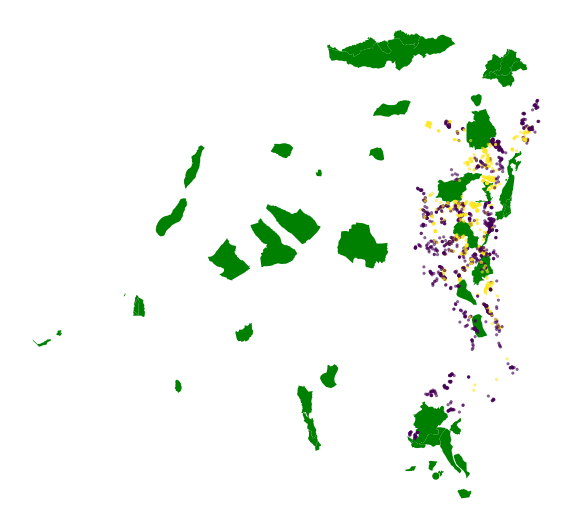

In [44]:
# %load _solved/solutions/case-conflict-mapping23.py
ax = protected_areas_utm.plot(figsize=(10, 10), color='green')
data_utm.plot(ax=ax, markersize=5, alpha=0.5, column='interference')
ax.set_axis_off()

<div class="alert alert-success">
 <b>EXERCISE</b>:
 
 In addition to the previous figure:
 <ul>
  <li>Give the mining sites a distinct color based on the `'mineral1'` column, indicating which mineral is the primary mined mineral.</li>
 </ul> 
</div>

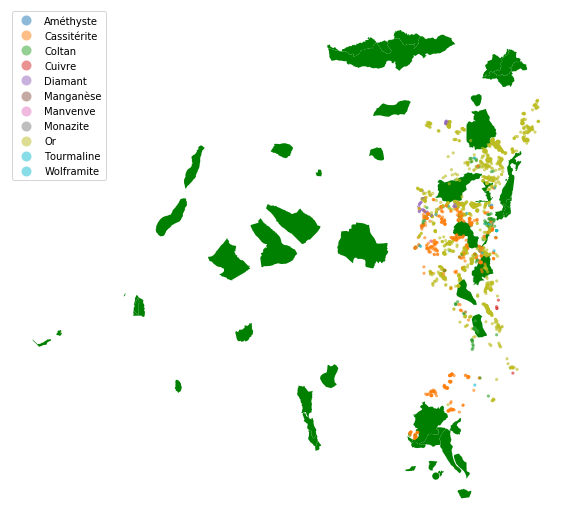

In [45]:
# %load _solved/solutions/case-conflict-mapping24.py
ax = protected_areas_utm.plot(figsize=(10, 10), color='green')
data_utm.plot(ax=ax, markersize=5, alpha=0.5, column='mineral1', legend=True)
ax.set_axis_off()

## 2. Spatial operations

<div class="alert alert-success">
 <b>EXERCISE</b>:
 
 <ul>
  <li>Access the geometry of the "Kahuzi-Biega National park".</li>
  <li>Filter the mining sites to select those that are located in this national park.</li>
 </ul> 
</div>

In [46]:
# %load _solved/solutions/case-conflict-mapping25.py
kahuzi = protected_areas_utm[protected_areas_utm['NAME_AP'] == "Kahuzi-Biega National park"].geometry.squeeze()

In [55]:
kahuzi_utm = protected_areas_utm[protected_areas_utm['NAME_AP'] == "Kahuzi-Biega National park"].geometry

In [56]:
kahuzi_utm = kahuzi_utm.to_crs(data_utm.crs)

In [47]:
# %load _solved/solutions/case-conflict-mapping26.py
mines_kahuzi = data_utm[data_utm.within(kahuzi)]
mines_kahuzi.head()

,pcode,vid,project,visit_date,name,workers_numb,interference,armed_group1,mineral1,geometry
659,codmine00680,1032,IPIS - PROMINES MoFA 2013-2014,2013-08-29Z,Ibozia/Kalumé,80.0,1.0,Raïa Mutomboki,Cassitérite,POINT (567832.7086093378 9759143.339360647)
660,codmine00681,1025,IPIS - PROMINES MoFA 2013-2014,2013-08-27Z,Matamba,150.0,1.0,Raïa Mutomboki,Cassitérite,POINT (598323.5389475008 9758688.142411157)
661,codmine00682,1031,IPIS - PROMINES MoFA 2013-2014,2013-08-28Z,Mutete/Mukina,170.0,1.0,Raïa Mutomboki,Cassitérite,POINT (570733.4369126211 9761871.114227083)
662,codmine00683,1033,IPIS - PROMINES MoFA 2013-2014,2013-08-29Z,Mutete,100.0,1.0,Raïa Mutomboki,Cassitérite,POINT (569881.0930415759 9762219.110778008)
758,codmine00779,1603,IPIS - PROMINES MoFA 2013-2014,2014-02-25Z,Mazankala,120.0,1.0,Raïa Mutomboki,Cassitérite,POINT (613075.5326777868 9722956.979837928)


In [59]:
print(mines_kahuzi.crs, kahuzi_utm.crs)

{'init': 'epsg:32735', 'no_defs': True} {'init': 'epsg:32735', 'no_defs': True}


In [49]:
# %load _solved/solutions/case-conflict-mapping27.py
print('Number of mines inside Kahuzi-Biega National park :', len(mines_kahuzi))

Number of mines inside Kahuzi-Biega National park : 12


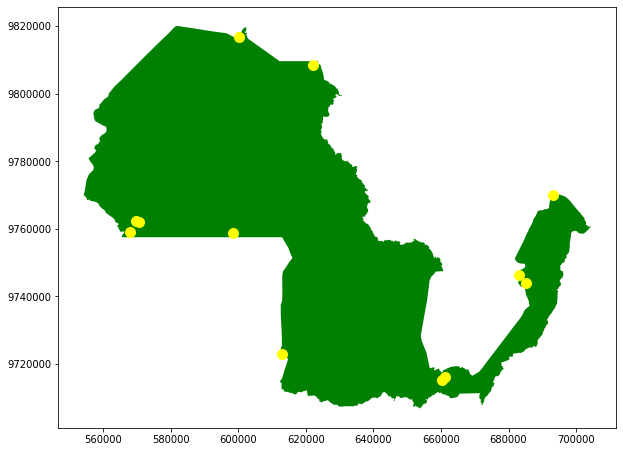

In [66]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect='equal'))
kahuzi_utm.plot(ax=ax, color='green')
mines_kahuzi.plot(ax=ax, markersize=100, alpha=1, color='yellow')
#ax.set_axis_off()

<div class="alert alert-success">
 <b>EXERCISE</b>: Determine for each mining site the "closest" protected area:
 
 <ul>
  <li> PART 1 - do this for a single mining site:
   <ul>
    <li>Get a single mining site, e.g. the first of the dataset.</li>
    <li>Calculate the distance (in km's) to all protected areas for this mining site</li>
    <li>Get the index of the minimum distance (tip: `idxmin()`) and get the name of the protected are corresponding to this index.</li>
   </ul> 
  </li>
  <li> PART 2 - apply this procedure on each geometry:
   <ul>
    <li>Write the above procedure as a function that gets a single site and the protected areas dataframe as input and returns the name of the closest protected area as output.</li>
    <li>Apply this function to all sites using the `.apply()` method on `data_utm.geometry`.</li>
   </ul> 
  </li>
 </ul> 
</div>

In [ ]:
# %load _solved/solutions/case-conflict-mapping28.py

In [ ]:
# %load _solved/solutions/case-conflict-mapping29.py

In [ ]:
# %load _solved/solutions/case-conflict-mapping30.py

In [ ]:
# %load _solved/solutions/case-conflict-mapping31.py

In [ ]:
# %load _solved/solutions/case-conflict-mapping32.py

## 3. Using spatial join to determine mining sites in the protected areas

Based on the analysis and visualizations above, we can already see that there are mining sites inside the protected areas. Let's now do an actual spatial join to determine which sites are within the protected areas.

### Mining sites in protected areas

<div class="alert alert-success">
 <b>EXERCISE</b>:
 <ul>
  <li>Add information about the protected areas to the mining sites dataset, using a spatial join:
   <ul>
    <li>Call the result `data_within_protected`</li>
    <li>If the result is empty, this is an indication that the coordinate reference system is not matching. Make sure to re-project the data (see above).</li>
      
   </ul>
  </li>
  <li>How many mining sites are located within a national park?</li>
  <li>Count the number of mining sites per national park (pandas tip: check `value_counts()`)</li>

 </ul> 

</div>

In [ ]:
# %load _solved/solutions/case-conflict-mapping33.py

In [ ]:
# %load _solved/solutions/case-conflict-mapping34.py

In [ ]:
# %load _solved/solutions/case-conflict-mapping35.py

In [ ]:
# %load _solved/solutions/case-conflict-mapping36.py

### Mining sites in the borders of protected areas

And what about the borders of the protected areas? (just outside the park)

<div class="alert alert-success">
 <b>EXERCISE</b>:
 <ul>
  <li>Create a new dataset, `protected_areas_borders`, that contains the border area (10 km wide) of each protected area:
   <ul>
    <li>Tip: one way of doing this is with the `buffer` and `difference` function.</li>
    <li>Plot the resulting borders as a visual check of correctness.</li>
   </ul>
  </li>
  <li>Count the number of mining sites per national park that are located within its borders</li>

 </ul> 

</div>

In [ ]:
# %load _solved/solutions/case-conflict-mapping37.py

In [ ]:
# %load _solved/solutions/case-conflict-mapping38.py

In [ ]:
# %load _solved/solutions/case-conflict-mapping39.py

In [ ]:
# %load _solved/solutions/case-conflict-mapping40.py

In [ ]:
# %load _solved/solutions/case-conflict-mapping41.py